# Let's start by installing all required libraries

In [1]:
!pip install numpy scikit_image scikit_learn matplotlib pandas -q

## Using scikit-image we can perform instance segmentation from a binary image
### Start by loading the phase_contrast and binary mask images

(np.float64(-0.5), np.float64(1375.5), np.float64(1023.5), np.float64(-0.5))

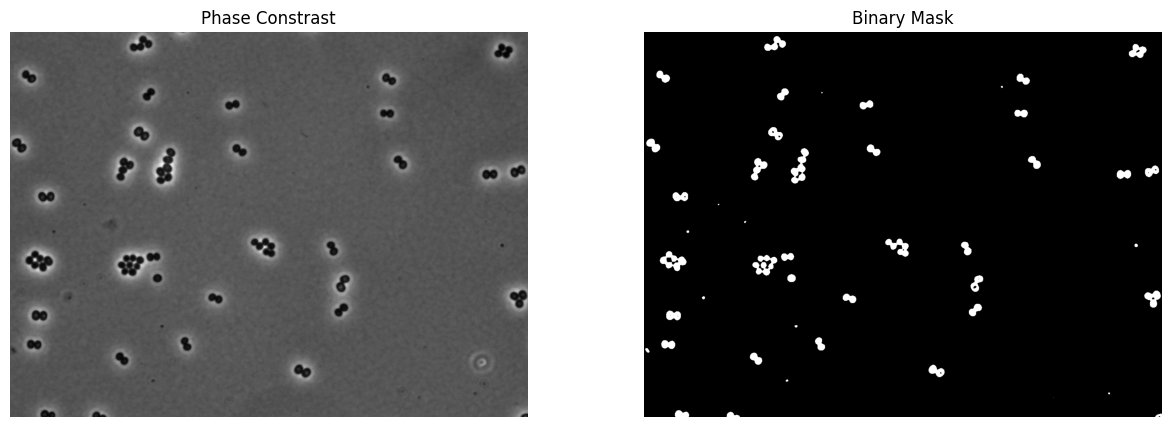

In [2]:
from skimage.io import imread
from matplotlib import pyplot as plt

phase = imread("../data/images/wt_phase_contrast.tif")
mask = imread("../data/images/wt_mask.tif")

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Phase Constrast')
plt.imshow(phase, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Binary Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')

### some cells have an opening, let's fill it using binary filling

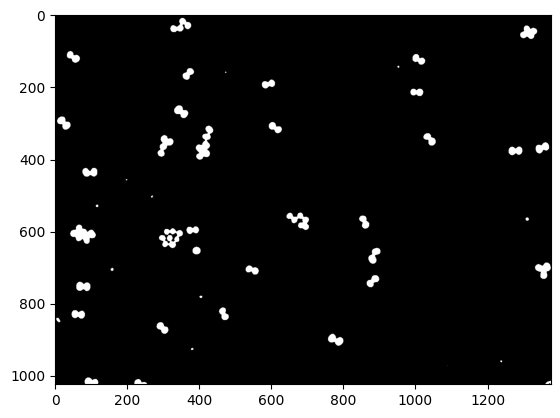

In [3]:
from scipy import ndimage as ndi
filled_mask = ndi.binary_fill_holes(mask)
plt.imshow(filled_mask, cmap="gray")

### Now let's use weighted watershed to create the single cell segmentations

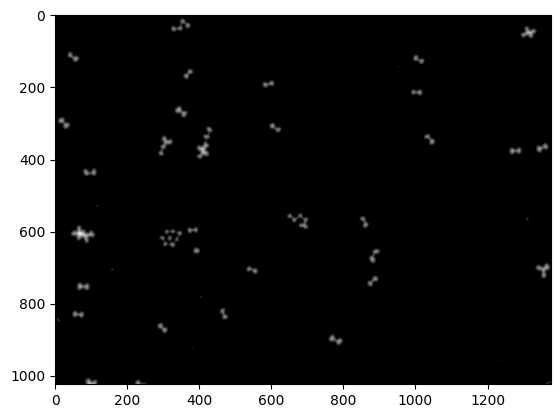

In [4]:
# start by calculating the euclidean distance of each pixel to the background
distance = ndi.distance_transform_edt(filled_mask)
plt.imshow(distance, cmap="gray")

In [5]:
# now we calculate the local maxima to find the center of individual regions
import numpy as np
from skimage.feature import peak_local_max
coordinates = peak_local_max(distance, labels=filled_mask)
local_maxima = np.zeros_like(filled_mask, dtype=bool)
local_maxima[tuple(coordinates.T)] = True
markers = ndi.label(local_maxima)[0]

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

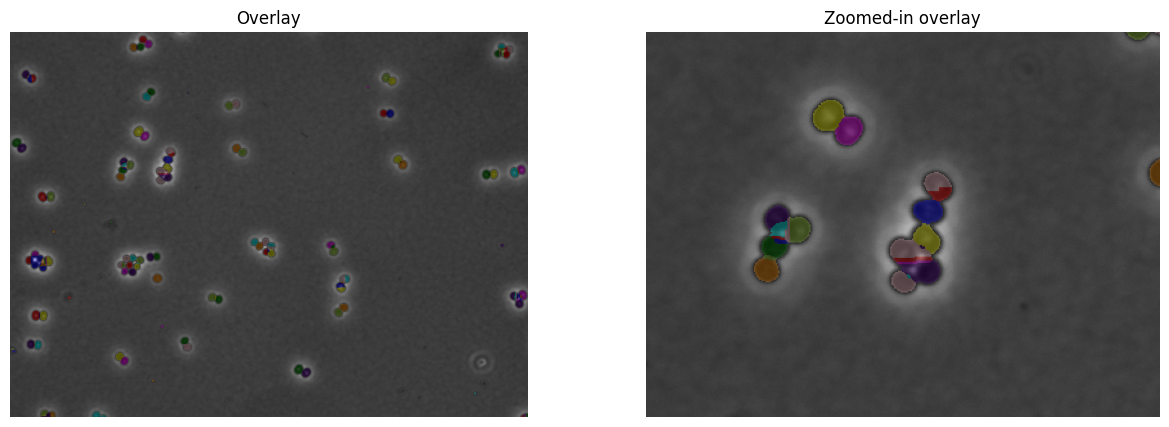

In [6]:
# now we run the watershed algorithm
from skimage.segmentation import watershed
labels = watershed(-distance, markers, mask=filled_mask)

# let's overlay the labels with the phase contrast image
from skimage.color import label2rgb
from skimage.exposure import rescale_intensity

overlay = label2rgb(labels, image=rescale_intensity(phase), bg_label=0, alpha=0.3, kind='overlay')

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Overlay')
plt.imshow(overlay, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Zoomed-in overlay")
plt.imshow(overlay[200:500, 200:600], cmap='gray')
plt.axis('off')

## Can we automatically filter out badly segmented cells?
### let's try to train a classifier that takes morphological measurements of single cells to know if they are well segmented or not
### (we will be using the dataset segmentation_quality.csv for this task)

In [7]:
import pandas as pd
data = pd.read_csv("../data/segmentation_quality.csv")

In [8]:
data

,Cell ID,Area,Perimeter,Length,Width,Eccentricity,Irregularity,Well Segmented
0,13,209,71,18.601075,15.000000,0.591364,4.911173,1
1,16,224,79,19.416488,15.811388,0.580405,5.278410,1
2,18,263,87,24.166092,15.652476,0.761892,5.364650,1
3,20,204,76,25.455844,12.041595,0.881042,5.321064,1
4,22,229,81,20.615528,15.524175,0.657983,5.352631,1
...,...,...,...,...,...,...,...,...
593,818,43666,1330,264.003788,242.909448,0.391687,6.364729,0
594,819,35400,1046,273.000000,190.000000,0.718070,5.559427,0
595,820,41211,1204,337.000000,162.000000,0.876878,5.930891,0
596,821,31447,1086,255.000000,174.000000,0.731023,6.124071,0


## Let's check class balance

<Axes: >

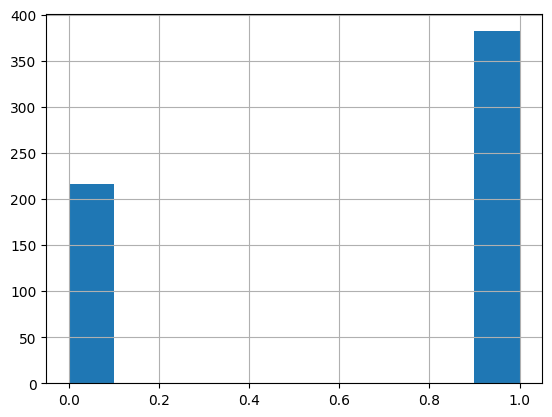

In [9]:
data["Well Segmented"].hist()

## This time we are going to implement undersampling to balance our classes

<Axes: >

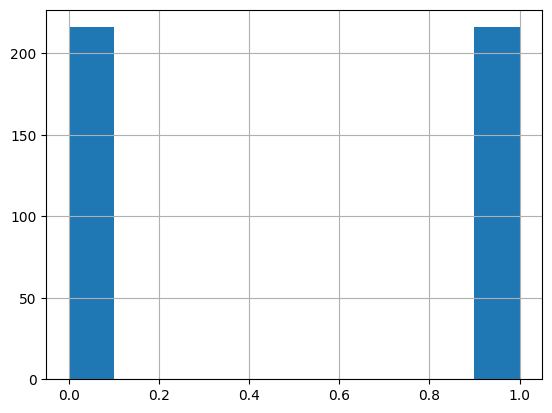

In [10]:
data_majority_undersampled = data[data["Well Segmented"] == 1].sample(n=len(data[data["Well Segmented"] == 0]), random_state=0)

data = pd.concat([data_majority_undersampled, data[data["Well Segmented"] == 0]]).reset_index(drop=True)
data["Well Segmented"].hist()

## Normalize data as before

In [11]:
from sklearn.preprocessing import StandardScaler

rows, columns = data.shape

## shuffle data
data = data.sample(frac=1,replace=False,random_state=0).reset_index(drop=True)

## standardize variables
cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity','Irregularity']

for col in cols:
  scaler = StandardScaler()
  data[col+"_scaled"] = scaler.fit_transform(data[[col]])

## split into train, test
train = data.loc[0:int(rows*0.8), :].copy() #separates 80% of data as training data
test = data.loc[int(rows*0.8):, :].copy() #separates 20% of data as validation data

## Let's try a logistic regression classifier

In [12]:
from sklearn.linear_model import LogisticRegression

x_cols = ['Area', 'Perimeter', 'Length', 'Width', 'Eccentricity']
y_col = 'Well Segmented'

# fit on training set
clf = LogisticRegression().fit(train[x_cols],train[y_col])

# predictions on test set
preds = clf.predict(test[x_cols])
# accuracy on test set
sum(preds==test[y_col])/test.shape[0]

0.8735632183908046

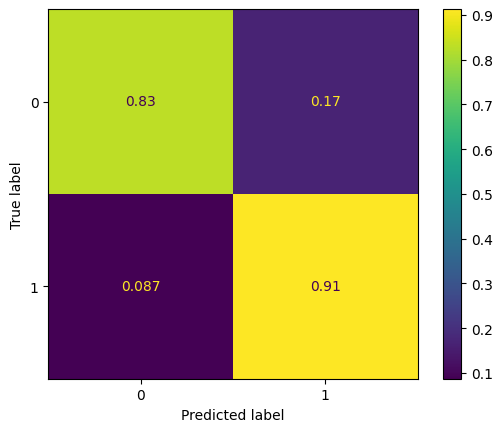

In [13]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

conf_mat = confusion_matrix(test[y_col],preds,normalize='true')
ConfusionMatrixDisplay(confusion_matrix=conf_mat).plot()

## Not too shabby! Let's now use this model to filter badly segmented cells
### Let's start by measuring the morphological features of the segmented cells

In [14]:
from skimage.measure import regionprops_table

measurements = regionprops_table(labels, properties=['label', 'area', 'perimeter', 'axis_major_length', 'axis_minor_length', 'eccentricity'])
measurements = pd.DataFrame.from_dict(measurements)
measurements = measurements.rename(columns={'label':'label', 'area':'Area', 'perimeter':'Perimeter', 'axis_major_length':'Length', 'axis_minor_length':'Width', 'eccentricity':'Eccentricity'})
measurements

,label,Area,Perimeter,Length,Width,Eccentricity
0,1,261.0,60.284271,19.673022,17.114369,0.493156
1,2,14.0,12.207107,7.017299,2.646208,0.926173
2,3,17.0,14.828427,9.191363,2.423177,0.964622
3,4,289.0,61.112698,20.087097,18.347937,0.407021
4,5,260.0,58.041631,19.110599,17.397147,0.413861
...,...,...,...,...,...,...
166,167,160.0,45.313708,15.676661,13.267033,0.532719
167,168,277.0,93.248737,34.818786,13.679519,0.919591
168,169,16.0,12.000000,4.472136,4.472136,0.000000
169,170,5.0,3.000000,5.656854,0.000000,1.000000


## Use the Logistic Regression model to predict if the cell is well segmented or and if not, remove it from the labels image

(np.float64(-0.5), np.float64(399.5), np.float64(299.5), np.float64(-0.5))

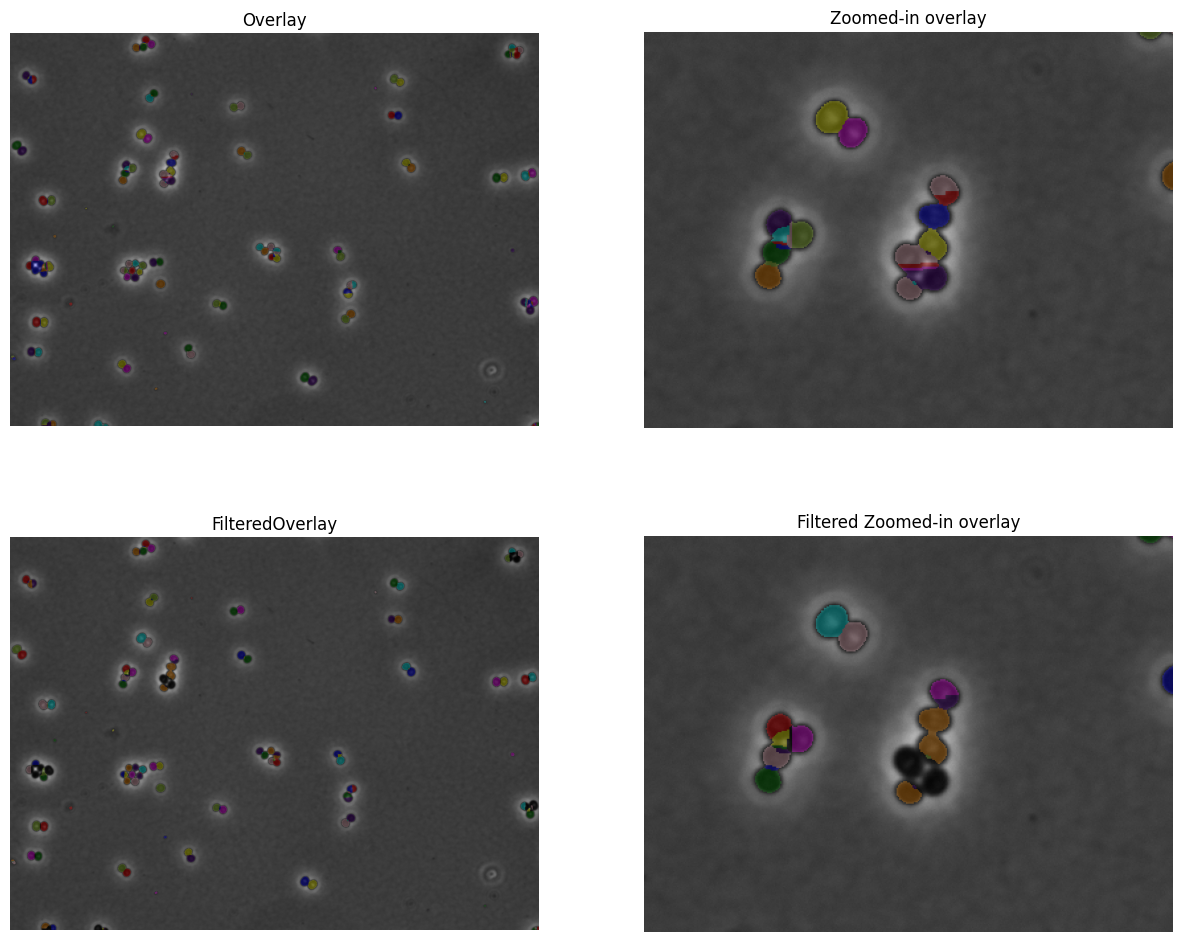

In [15]:
preds = clf.predict(measurements[x_cols])

filtered_labels = labels.copy()
for index, label in enumerate(measurements['label']):
    if preds[index] == 0:
        filtered_labels[filtered_labels == label] = 0

filtered_overlay = label2rgb(filtered_labels, image=rescale_intensity(phase), bg_label=0, alpha=0.3, kind='overlay')

plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.title('Overlay')
plt.imshow(overlay, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title("Zoomed-in overlay")
plt.imshow(overlay[200:500, 200:600], cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.title('FilteredOverlay')
plt.imshow(filtered_overlay, cmap='gray')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.title("Filtered Zoomed-in overlay")
plt.imshow(filtered_overlay[200:500, 200:600], cmap='gray')
plt.axis('off')

## Exercise: Apply the same steps to the sle1 dataset

In [16]:
# your code here

## Exercise: Try a different classifier

In [17]:
# your code here